## 1. 환경 설정

`(1) Env 환경변수`

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [3]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

## 2. State Reducer
- Reducer는 LangGraph에서 상태 업데이트를 관리하는 중요한 개념
- 그래프의 각 노드의 출력을 그래프의 상태에 통합하는 방법을 정의
- Reducer의 필요성
    - 상태 덮어쓰기 문제: 기본적으로 각 노드의 반환값은 해당 상태 키의 이전 값을 덮어쓰는 방식으로 동작 (override)
    - 누적 업데이트 필요: 특히 메시지 리스트와 같은 경우, 이전 상태에 새로운 값을 추가하고 싶을 때가 있음 

`(1) Reducer를 별도로 지정하지 않은 경우 `
- reducer를 별도로 지정하지 않은 경우 기존 값을 덮어쓰는 방식으로 동작
- 기본 reducer는 상태에 대해 별도의 설정 없이 사용될 때 자동으로 적용

In [ ]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 상태 정의 
class DocumentState(TypedDict):
    query: str
    documents: List[str]

# Node 1: query 업데이트
def node_1(state: DocumentState) -> DocumentState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: DocumentState) -> DocumentState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: DocumentState) -> DocumentState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}


# 그래프 빌드
builder = StateGraph(DocumentState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))


In [5]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요."}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
최종 상태: {'query': '채식주의자를 위한 비건 음식을 추천해주세요.', 'documents': ['doc2.pdf', 'doc4.pdf', 'doc5.pdf']}


`(2) Reducer를 별도로 지정하는 경우 `
- `Annotated` 사용하여 지정한 reducer 작동 방식에 따라 기존 상태 정보를 업데이트 
- 리스트를 병합하는 `operator.add`를 사용하면, activity_log를 누적하는 방식으로 노드를 구현

In [ ]:
from operator import add
from typing import Annotated, TypedDict

class ReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], add]

# Node 1: query 업데이트
def node_1(state: ReducerState) -> ReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: ReducerState) -> ReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: ReducerState) -> ReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(ReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요."}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
최종 상태: {'query': '채식주의자를 위한 비건 음식을 추천해주세요.', 'documents': ['doc1.pdf', 'doc2.pdf', 'doc3.pdf', 'doc2.pdf', 'doc4.pdf', 'doc5.pdf']}


`(3) Custom Reducer 사용 `
- 상태 업데이트가 기본적인 덮어쓰기나 병합만으로 해결되지 않을 때 유용한 방법
- 중복 제거, 최대/최소 값 유지, 조건부 병합 등의 특정 비즈니스 로직이 필요한 경우에 적용

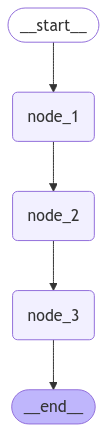

In [8]:
from typing import TypedDict, List, Annotated

# Custom reducer: 중복된 문서를 제거하며 리스트 병합
def reduce_unique_documents(left: list | None, right: list | None) -> list:
    """Combine two lists of documents, removing duplicates."""
    if not left:
        left = []
    if not right:
        right = []
    # 중복 제거: set을 사용하여 중복된 문서를 제거하고 다시 list로 변환
    return list(set(left + right))

# 상태 정의 (documents 필드 포함)
class CustomReducerState(TypedDict):
    query: str
    documents: Annotated[List[str], reduce_unique_documents]  # Custom Reducer 적용


# Node 1: query 업데이트
def node_1(state: CustomReducerState) -> CustomReducerState:
    print("---Node 1 (query update)---")
    query = state["query"]
    return {"query": query}

# Node 2: 검색된 문서 추가 
def node_2(state: CustomReducerState) -> CustomReducerState:
    print("---Node 2 (add documents)---")
    return {"documents": ["doc1.pdf", "doc2.pdf", "doc3.pdf"]}

# Node 3: 추가적인 문서 검색 결과 추가
def node_3(state: CustomReducerState) -> CustomReducerState:
    print("---Node 3 (add more documents)---")
    return {"documents": ["doc2.pdf", "doc4.pdf", "doc5.pdf"]}

# 그래프 빌드
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# 논리 구성
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", "node_3")
builder.add_edge("node_3", END)

# 그래프 실행
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# 초기 상태
initial_state = {"query": "채식주의자를 위한 비건 음식을 추천해주세요.", "documents": []}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

---Node 1 (query update)---
---Node 2 (add documents)---
---Node 3 (add more documents)---
최종 상태: {'query': '채식주의자를 위한 비건 음식을 추천해주세요.', 'documents': ['doc3.pdf', 'doc5.pdf', 'doc4.pdf', 'doc2.pdf', 'doc1.pdf']}


## 3. MessageGraph
- LangChain의 ChatModel은 Message 객체 목록을 입력으로 처리 (StateGraph의 특수한 유형)
- 이러한 메시지들은 HumanMessage(사용자 입력)나 AIMessage(LLM 응답) 등 다양한 형태로 제공

`(1) Messages State 정의`
- 이전 대화 기록을 그래프 상태에 메시지 목록으로 저장하는 것이 유용
- 그래프 상태에 Message 객체 목록을 저장하는 키(채널)를 추가하고, 이 키에 리듀서 함수를 추가 
- 리듀서 함수 선택:
    - operator.add를 사용하면: 새 메시지를 기존 목록에 단순히 추가
    - add_messages 함수를 사용하면:
        - 새 메시지는 기존 목록에 추가
        - 기존 메시지 업데이트도 올바르게 처리 (메시지 ID를 추적)

In [10]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# 기본 State 초기화 방법을 사용
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [11]:
# LangGraph MessagesState라는 미리 만들어진 상태를 사용
from langgraph.graph import MessagesState
from typing import List
from langchain_core.documents import Document

class GraphState(MessagesState):
    # messages 키는 기본 제공 - 다른 키를 추가하고 싶을 경우 아래 주석과 같이 적용 가능 
    documents: List[Document]
    grade: float
    num_generation: int

`(2) RAG Chain 구성`
- 메뉴 검색을 위한 벡터저장소를 초기화 (기존 저장소를 로드)
- LangChain Runnable로 구현

In [15]:
from langchain_chroma import Chroma
from langchain_ollama  import OllamaEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

embeddings_model = OllamaEmbeddings(model="bge-m3") 

# Chroma 인덱스 로드
vector_db = Chroma(
    embedding_function=embeddings_model,   
    collection_name="restaurant_menu",
    persist_directory="./chroma_db",
)

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini")

# RAG 체인 구성
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

system = """
You are a helpful assistant. Use the following context to answer the user's question:

[Context]
{context}
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

# 검색기 정의
retriever = vector_db.as_retriever(
    search_kwargs={"k": 2}
)

# RAG 체인 구성
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

# RAG 체인 실행
query = "채식주의자를 위한 메뉴를 추천해주세요."
response = rag_chain.invoke(query)

# 답변 출력
print(response)

채식주의자를 위한 메뉴로 다음과 같은 옵션을 추천드립니다:

1. **채소 볶음밥** - 다양한 채소와 함께 조리한 볶음밥으로, 간장이나 고추장을 넣어 간을 맞추면 맛있습니다.

2. **퀴노아 샐러드** - 퀴노아, 신선한 채소(오이, 토마토, 파프리카 등), 아보카도, 그리고 레몬 드레싱을 곁들인 샐러드입니다.

3. **채소 카레** - 감자, 당근, 브로콜리 등 다양한 채소를 넣어 만든 카레로, 밥이나 난과 함께 즐길 수 있습니다.

4. **두부 스테이크** - 양념한 두부를 구워서 채소와 함께 서빙하면 맛있고 건강한 한 끼가 됩니다.

5. **비건 파스타** - 토마토 소스나 올리브 오일, 마늘로 만든 소스를 곁들인 파스타로, 채소를 추가하면 더욱 풍부한 맛을 냅니다.

6. **렌틸콩 수프** - 렌틸콩과 다양한 채소를 넣고 끓인 수프로, 영양가가 높고 따뜻한 한 끼로 좋습니다.

이 외에도 다양한 채식 메뉴가 많이 있으니, 취향에 맞게 조리해 보세요!


`(3) 노드(Node)`

In [16]:
# RAG 수행 함수 정의
def retrieve_and_respond(state: GraphState):
    last_human_message = state['messages'][-1]
    
    # HumanMessage 객체의 content 속성에 접근
    query = last_human_message.content
    
    # 문서 검색
    retrieved_docs = retriever.invoke(query)
    
    # 응답 생성
    response = rag_chain.invoke(query)
    
    # 검색된 문서와 응답을 상태에 저장
    return {
        "messages": [AIMessage(content=response)],
        "documents": retrieved_docs
    }

In [17]:
from pydantic import BaseModel, Field

class GradeResponse(BaseModel):
    "A score for answers"
    score: float = Field(..., ge=0, le=1, description="A score from 0 to 1, where 1 is perfect")
    explanation: str = Field(..., description="An explanation for the given score")

# 답변 품질 평가 함수
def grade_answer(state: GraphState):
    messages = state['messages']
    question = messages[-2].content
    answer = messages[-1].content
    context = format_docs(state['documents'])

    grading_system = """You are an expert grader. 
    Grade the following answer based on its relevance and accuracy to the question, considering the given context. 
    Provide a score from 0 to 1, where 1 is perfect, along with an explanation."""

    grading_prompt = ChatPromptTemplate.from_messages([
        ("system", grading_system),
        ("human", "[Question]\n{question}\n\n[Context]\n{context}\n\n[Answer]\n{answer}\n\n[Grade]\n")
    ])
    
    grading_chain = grading_prompt | llm.with_structured_output(schema=GradeResponse)
    
    grade_response = grading_chain.invoke({
        "question": question,
        "context": context,
        "answer": answer
    })

    # 답변 생성 횟수를 증가 
    num_generation = state.get('num_generation', 0)
    num_generation += 1
    
    return {"grade": grade_response.score, "num_generation": num_generation}

`(4) 엣지(Edge)`

In [18]:
from typing import Literal


def should_retry(state: GraphState) -> Literal["retrieve_and_respond", "generate"]:
    print("----GRADTING---")
    print("Grade Score: ", state["grade"])

    # 답변 생성 횟수가 3회 이상이면 "generate"를 반환
    if state["num_generation"] > 2: 
        return "generate"    
    
    # 답변 품질 평가점수가 0.7 미만이면 RAG 체인을 다시 실행 
    if state["grade"] < 0.7:  
        return "retrieve_and_respond"
    else:
        return "generate"

`(5) 그래프(Graph) 구성`

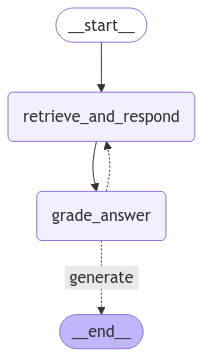

In [19]:
# 그래프 설정
builder = StateGraph(GraphState)
builder.add_node("retrieve_and_respond", retrieve_and_respond)
builder.add_node("grade_answer", grade_answer)

builder.add_edge(START, "retrieve_and_respond")
builder.add_edge("retrieve_and_respond", "grade_answer")
builder.add_conditional_edges(
    "grade_answer",
    should_retry,
    {
        "retrieve_and_respond": "retrieve_and_respond",
        "generate": END
    }
)

# 그래프 컴파일
graph = builder.compile()

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(6) Graph 실행`

In [24]:
# 초기 상태
initial_state = {
    "messages": [HumanMessage(content="채식주의자를 위한 메뉴를 추천해주세요.")],
}

# 그래프 실행 
final_state = graph.invoke(initial_state)

# 최종 상태 출력
print("최종 상태:", final_state)

----GRADTING---
Grade Score:  1.0
최종 상태: {'messages': [HumanMessage(content='채식주의자를 위한 메뉴를 추천해주세요.', additional_kwargs={}, response_metadata={}, id='09f72905-5975-4d29-a773-1fd7cbaa00f7'), AIMessage(content='채식주의자를 위한 메뉴로는 다음과 같은 다양한 선택지를 추천합니다:\n\n1. **채소 샐러드**: 신선한 채소(상추, 시금치, 토마토, 오이 등)와 다양한 드레싱(올리브 오일, 발사믹 식초 등)을 곁들인 샐러드. 아보카도나 견과류를 추가하면 더욱 맛있습니다.\n\n2. **퀴노아 볼**: 퀴노아를 기본으로 하고, 구운 채소(브로콜리, 당근, 고구마 등)와 병아리콩, 아보카도를 올려서 건강한 한 끼로 즐길 수 있습니다.\n\n3. **채소 스파게티**: 호박면이나 통밀 스파게티에 토마토 소스와 다양한 채소(버섯, 시금치, 양파 등)를 넣어 만든 파스타.\n\n4. **비건 버거**: 렌틸콩, 검은콩 또는 병아리콩으로 만든 패티에 신선한 채소와 아보카도를 넣어 버거를 만들어 보세요.\n\n5. **커리**: 다양한 채소와 렌틸콩 또는 두부를 넣고 향신료와 코코넛 밀크로 만든 커리. 밥이나 난과 함께 즐길 수 있습니다.\n\n6. **스무디 볼**: 바나나, 시금치, 아몬드 밀크 등을 블렌딩하여 만든 스무디에 과일, 견과류, 그래놀라를 토핑으로 올린 건강한 아침 식사.\n\n7. **타파스 스타일 안주**: 올리브, 구운 피망, 호박, 아스파라거스, 후무스 등을 곁들인 작은 안주 플레이트.\n\n이 외에도 다양한 채식 요리들이 있으니 취향에 맞게 선택해 보세요!', additional_kwargs={}, response_metadata={}, id='4ce937dc-ba91-4b7c-adc2-775731f4c118')], 'documents': [], 'grade': 1.0, 'num_generat

In [23]:
# 최종 답변만 출력
pprint(final_state['messages'][-1].content) 

('채식주의자를 위한 메뉴로 다음과 같은 요리들을 추천할 수 있습니다:\n'
 '\n'
 '1. **채소 스튜**: 다양한 채소(감자, 당근, 브로콜리, 호박 등)를 넣고 허브와 향신료로 맛을 낸 스튜입니다.\n'
 '\n'
 '2. **퀴노아 샐러드**: 퀴노아에 오이, 토마토, 아보카도, 레몬즙, 올리브유를 넣고 섞은 상큼한 샐러드입니다.\n'
 '\n'
 '3. **채식 타코**: 렌틸콩이나 검은콩, 다양한 채소(양파, 피망, 아보카도 등)를 넣고 타코 셸에 담아 먹는 요리입니다.\n'
 '\n'
 '4. **버섯 리조또**: 아르보리오 쌀에 버섯과 채소 육수를 넣고 끓여 만든 크리미한 리조또입니다.\n'
 '\n'
 '5. **두부 스테이크**: 두부를 두껍게 썰어 마리네이드한 후 구워서 만든 스테이크로, 소스와 함께 제공합니다.\n'
 '\n'
 '6. **비건 피자**: 토마토 소스에 다양한 채소와 비건 치즈를 올려 구운 피자입니다.\n'
 '\n'
 '7. **채식 카레**: 코코넛 밀크와 다양한 채소, 병아리콩을 넣고 만든 향긋한 카레입니다.\n'
 '\n'
 '이 외에도 다양한 채식 요리가 있으니 취향에 맞춰 즐겨보세요!')


## 4. Gradio 챗봇

In [ ]:
import gradio as gr
from typing import List, Tuple

# 예시 질문들
example_questions = [
    "채식주의자를 위한 메뉴를 추천해주세요.",
    "오늘의 스페셜 메뉴는 무엇인가요?",
    "파스타에 어울리는 음료는 무엇인가요?"
]

# 대답 함수 정의
def answer_invoke(message: str, history: List[Tuple[str, str]]) -> str:
    try:
        # 채팅 기록을 AI에게 전달할 수 있는 형식으로 변환
        chat_history = []
        for human, ai in history:
            chat_history.append(HumanMessage(content=human))
            chat_history.append(AIMessage(content=ai))

        # 기존 채팅 기록에 사용자의 메시지를 추가 (최근 2개 대화만 사용)
        initial_state = {
            "messages": chat_history[-2:]+[HumanMessage(content=message)],  
        }

        # 메시지를 처리하고 최종 상태를 반환
        final_state = graph.invoke(initial_state)
        
        # 최종 상태에서 필요한 부분 반환 (예: 추천 메뉴 등)
        return final_state["messages"][-1].content
        
    except Exception as e:
        # 오류 발생 시 사용자에게 알리고 로그 기록
        print(f"Error occurred: {str(e)}")
        return "죄송합니다. 응답을 생성하는 동안 오류가 발생했습니다. 다시 시도해 주세요."


# Gradio 인터페이스 생성
demo = gr.ChatInterface(
    fn=answer_invoke,
    title="레스토랑 메뉴 AI 어시스턴트",
    description="메뉴 정보, 추천, 음식 관련 질문에 답변해 드립니다.",
    examples=example_questions,
    theme=gr.themes.Soft()
)

# Gradio 앱 실행
demo.launch()


In [ ]:
# 데모 종료
demo.close()